# Exploring metal subgenres with Python

An exploration. We invariably end up doing some processing that we don't directly need, but that would be useful for a future analysis, or one of your own. Choose your own adventure.

## Table of contents

[Part I: Scraping, cleaning, & clustering](#Part-I:-Scraping,-cleaning,-&-clustering)
* [Scraping](#Scraping)
* [Cleaning up the data](#Cleaning-up-the-data)
* [Creating a feature vector](#Creating-a-feature-vector)
* [Dimensionality reduction](#Dimensionality-reduction) with PCA
* [Clustering genres](#Clustering-genres) with $k$-means or DBSCAN

[Part II: Exploring clusters](#Part-II:-Visualizing-clusters)
* [How large are our clusters?](#How-large-are-our-clusters?)
* [Where are these clusters?](#Where-are-these-clusters?)
* [Finding the top 10 countries per cluster](#Finding-the-top-10-countries-per-cluster)
* [Everyone loves word clouds](#Everyone-loves-word-clouds)
* [A network of genres](#A-network-of-genres)
* [Enter the Circos plot](#Enter-the-Circos-plot)

[Conclusion](#Conclusion)

## Requirements

This notebook was written using Python 3.5. If you're following along with this notebook, you should have roughly up to date versions of the following libraries (installable via pip, conda, or your package manager of choice):

* requests
* BeautifulSoup4
* pandas
* numpy
* matplotlib
* seaborn (optional)
* scikit-learn
* wordcloud
* networkx
* circos

# Part I: Scraping, cleaning, & clustering

## Scraping

The data can be obtained by running the script `MA_scraper.py`.
<!--Or, if you've cloned the [ma-scraper repo](https://github.com/jonchar/ma-scraper) you'll already have an example dataset.-->
It scrapes M-A for a listing of band names alphabetically (as seen [here](http://www.metal-archives.com/lists/A) for example). The site uses AJAX to retrieve band names and display them in the page. It does so in chunks of 500 bands. From inspecting the page source it was easy to guess the location and naming of the URLs from which the band names are retrieved. Towards the bottom of the page source, you can find this line of JavaScript which generates the table of band names:

     var grid = createGrid("#bandListAlpha", 500, 'browse/ajax-letter/l/A/json/1', ... );
     
This line uses data retrieved from `www.metal-archives.com/`**`browse/ajax-letter/l/A/json/1`**`/{A-Z}` to generate the grid of links displayed on the page. The link indicates that the data is probably returned in JSON format to the browser when generating the grid. This turns out to be the case and is what is assumed in `MA_scraper.py`.

The output data is stored as a CSV file with the name `MA-band-names_YYYY-MM-DD.csv`.

In [1]:
import string
import re
import itertools

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, rgb2hex
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from wordcloud import WordCloud, ImageColorGenerator

import networkx as nx

from circos import CircosPlot

### Read in the raw scraped data

In [2]:
data = pd.read_csv('MA-band-names_2016-04-01.csv', index_col=0) # Change the date to match the date you scraped!

In [3]:
data.head()

,NameLink,Country,Genre,Status
0,<a href='http://www.metal-archives.com/bands/0...,Finland,Doom Metal,"<span class=""split_up"">Split-up</span>"
1,<a href='http://www.metal-archives.com/bands/0...,Greece,Death/Thrash Metal,"<span class=""active"">Active</span>"
2,<a href='http://www.metal-archives.com/bands/0...,Slovakia,Industrial Experimental Metal,"<span class=""active"">Active</span>"
3,<a href='http://www.metal-archives.com/bands/1...,Australia,Death Metal/Groove Metal,"<span class=""active"">Active</span>"
4,<a href='http://www.metal-archives.com/bands/1...,United States,Thrash/Heavy Metal,"<span class=""changed_name"">Changed name</span>"


## Cleaning up the data

We have a little bit of cleaning up to do:

1. The `NameLink` column contains the band name and it's respective M-A link. we should pull out the link and band name and put them into their own columns.
2. The `Status` column has some styling information that isn't necessarily useful to us so if we can pull out just the text that would be better.
3. The `Genre` column contains a string descriptor of the band's genre, which I'm not sure is standardized. Tokenizing these strings will help us in quantifying which terms occur most often.

### Processing band names

Here we'll make use of the `map` method of the `pd.Series` class to achieve what we want. First the `NameLink` column. We'll use BeautifulSoup to parse the HTML contained within, then use the results to construct the columns we desire (one column with the band name and another with it's corresponding M-A link).

In [4]:
data['NameSoup'] = data['NameLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser'))
data['BandName'] = data['NameSoup'].map(lambda soup: soup.text)      # extracts band name
data['BandLink'] = data['NameSoup'].map(lambda soup: soup.a['href']) # extracts link to band's page on M-A

### Processing band status

Next we'll take a similar approach for extracting each band's status. Here we end up *replacing* the original `Status` column.

In [5]:
data['StatusSoup'] = data['Status'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser'))
data['Status'] = data['StatusSoup'].map(lambda soup: soup.text)

Now let's check to see that our mappings worked and the columns `BandName`, `BandLink`, and `Status` have the correctly formatted information.

In [6]:
data[['BandName', 'BandLink', 'Status']].head()

,BandName,BandLink,Status
0,0 X í S T,http://www.metal-archives.com/bands/0_X_%C3%AD...,Split-up
1,0 Zone,http://www.metal-archives.com/bands/0_Zone/354...,Active
2,0N0,http://www.metal-archives.com/bands/0N0/354032...,Active
3,1 Shot Kill,http://www.metal-archives.com/bands/1_Shot_Kil...,Active
4,10 Kingdoms,http://www.metal-archives.com/bands/10_Kingdom...,Changed name


### Processing band genre data

Here we'll tokenize the string in the `Genre` column to obtain a list of terms. This should help us in identifying all of the keywords used to describe bands in terms of genre. To do this, we'll replace all punctuation with spaces and then split the strings on spaces to get our list of terms.

In [7]:
def replace_punctuation(raw, replacement=' '):
    """Replaces all punctuation in the input string `raw` with a space.
    Returns the new string."""
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    output = regex.sub(replacement, raw)
    return output

def split_terms(raw):
    """Splits the terms in the input string `raw` on all spaces and punctuation.
    Returns a list of the terms in the string."""
    replaced = replace_punctuation(raw, replacement=' ')
    output = tuple(replaced.split())
    return output

Now we can split the strings in the `Genre` column into separte terms with a simple map. We'll also replace the term "Metal" itself with an empty string.

In [8]:
data['GenreTerms'] = data['Genre'].str.replace('Metal', '').map(split_terms)

#### Finding the most common unique terms

Now that we have the genre descriptors tokenized, we'll compile a list of unique terms. This will make it easier to do some quantification later on. To do this we'll first flatten the column `GenreTerms` into a list, then use the `np.unique()` function to get the unique terms and their corresponding counts.

In [9]:
all_terms = list(itertools.chain.from_iterable(data['GenreTerms']))      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

## Creating a feature vector

Before we can feed our data to some unsupervised machine learning algorithms, we need to generate a mathematical representation of it.

One simple way to represent our data is with a binary matrix where each column represents the presence of a unique genre term and each row corresponds to a band. For example, a band with the genre descriptor `'Black/Death Metal'`, would have the tokenized genre terms `('Death', 'Black')`, and a binarized vector with a 1 in the columns corresponding to Death and Black, but with zeros in every other column. We can do this with scikit-learn's `MultiLabelBinarizer` class. The resulting feature matrix with have the shape `n_bands` by `n_unique_terms`. We'll use a subset of our data because it may be too large to process in a reasonable amount of time on a single machine.

In [10]:
# Take every Nth band from the scraped data set, use the whole set at your own risk!
subset = data['GenreTerms'][::5]

In [11]:
mlb = MultiLabelBinarizer()
mlb.fit([[x] for x in [term for term in unique_terms]])
# We can use 8-bit integers to save on memory since it is only a binary matrix.
binarized_terms = mlb.transform(subset).astype('int8')

In [12]:
binarized_terms.shape # (n_bands x n_unique_terms)

(21470, 293)

To get an idea of what our data now looks like, we'll make a visual representation of our binarized matrix using matplotlib's `imshow`. Each black spot represents the presence of a unique genre descriptor for a given band.

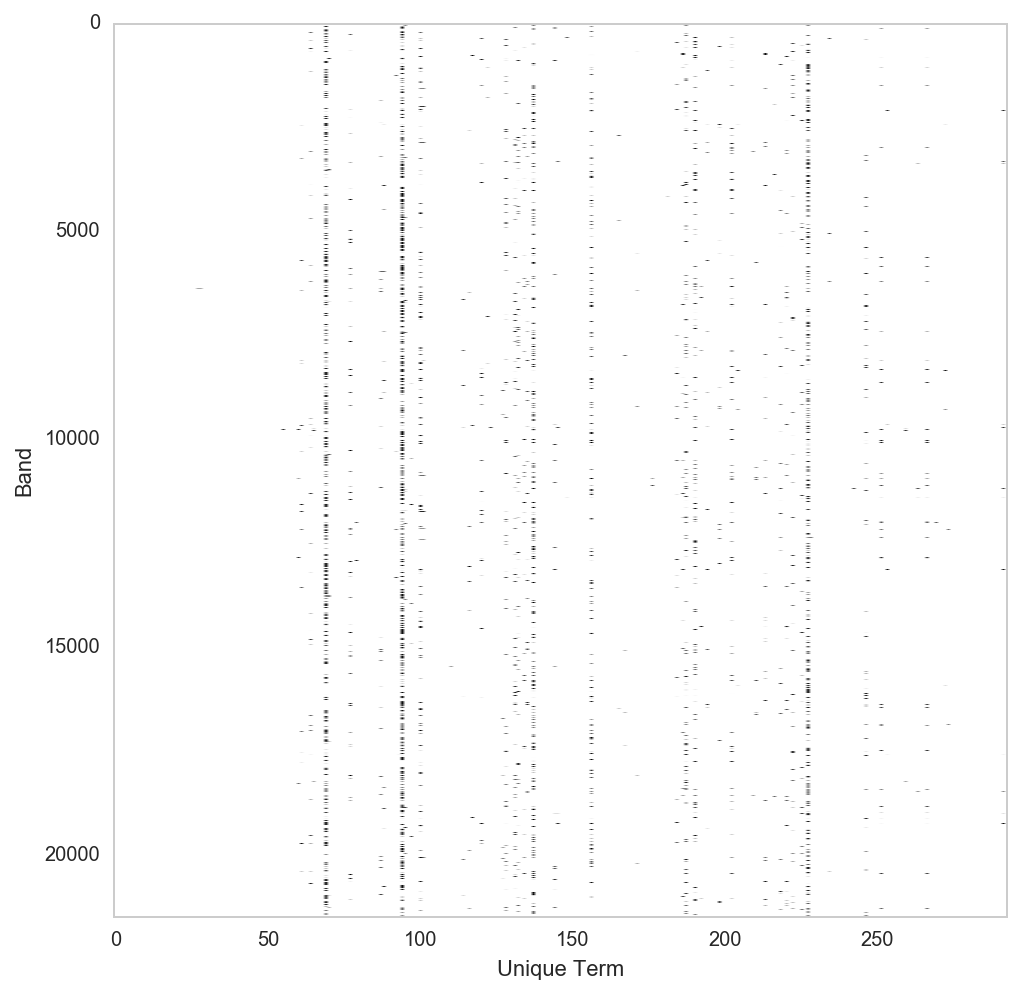

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(binarized_terms, aspect='auto')
ax.grid('off')
ax.set_ylabel('Band')
ax.set_xlabel('Unique Term')

The vertical trends we're seeing indicate genre terms repeated over bands. What this suggests should be obvious: *some terms are more common than others*. We can verify this by looking at the counts for the top genre terms that we extracted above and stored in `genre_terms`. The indices of the top terms should correspond with where the appear on the binary plot. Let's double check this for sanity.

In [14]:
genre_terms.head(10)

,Term,TotalCount
94,Death,36633
69,Black,27528
227,Thrash,23336
137,Heavy,15421
156,Melodic,9495
100,Doom,7710
190,Progressive,7488
187,Power,6711
131,Grindcore,4031
202,Rock,3745


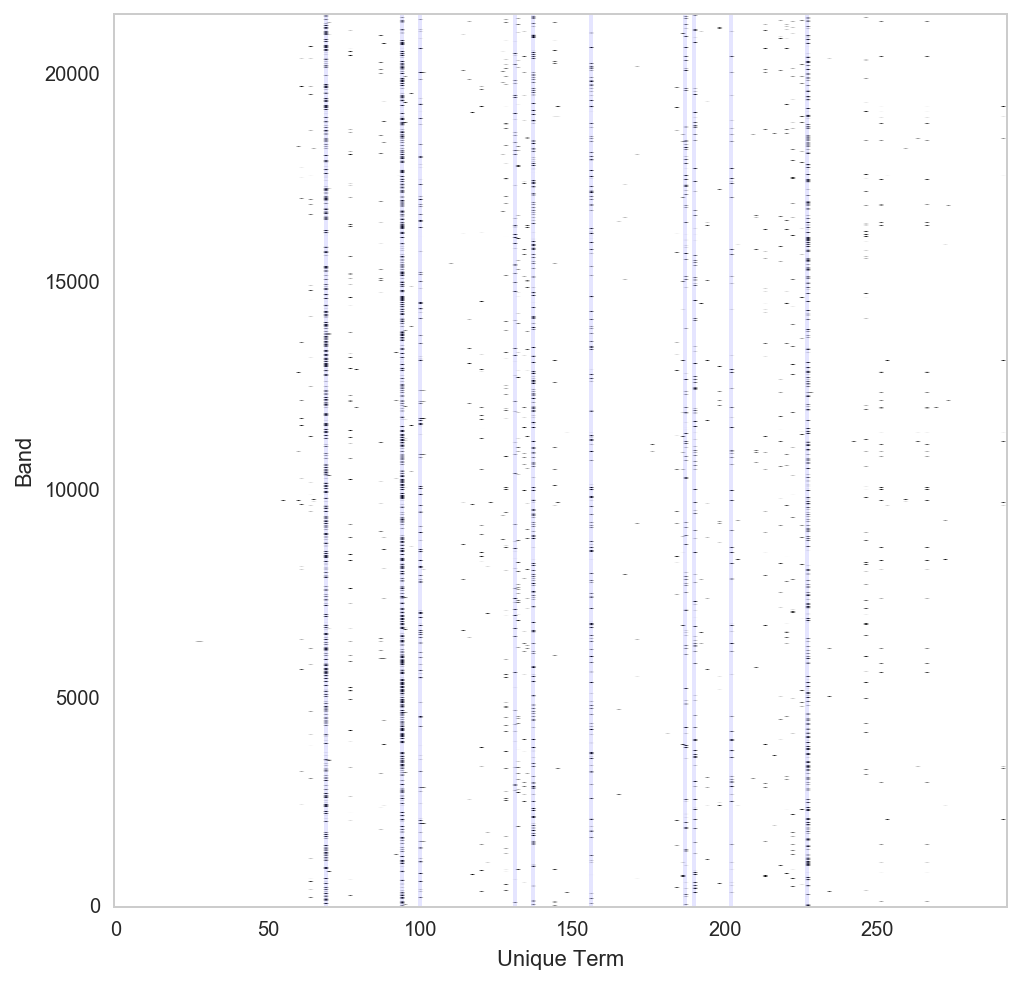

In [15]:
popular_term_locations = genre_terms.index[:10]

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(binarized_terms, aspect='auto', origin='lower')
ax.grid('off')
ax.set_ylabel('Band')
ax.set_xlabel('Unique Term')
for location in popular_term_locations:
    ax.axvline(location, lw=2, alpha=0.1)

The vertical lines we plotted do indeed line up with frequenly used genre terms. Sanity checked!

## Dimensionality reduction

As you can see our feature vector is one big matrix. The first step in almost any data exploration (IMO) should be to create a simple visualization of your data. Since each of our bands is described by a 293-dimension feature vector, some dimensionality reduction is in order.

### Principal Component Analysis (PCA)

While not technically an algorithm for dimensionality reduction (it's truly a decomposition algorithm), PCA can be used to find the axes in our feature space that capture the greatest amount of variance within the data. These axes are known as the principal components. Taking only the top components therefore is an effective way of "reducing" the dimensionality of your original data set.

In [16]:
pca = PCA()
components = pca.fit_transform(binarized_terms)

Now we can visualize combinations of first three primary components to get an idea of any structure in our data set.

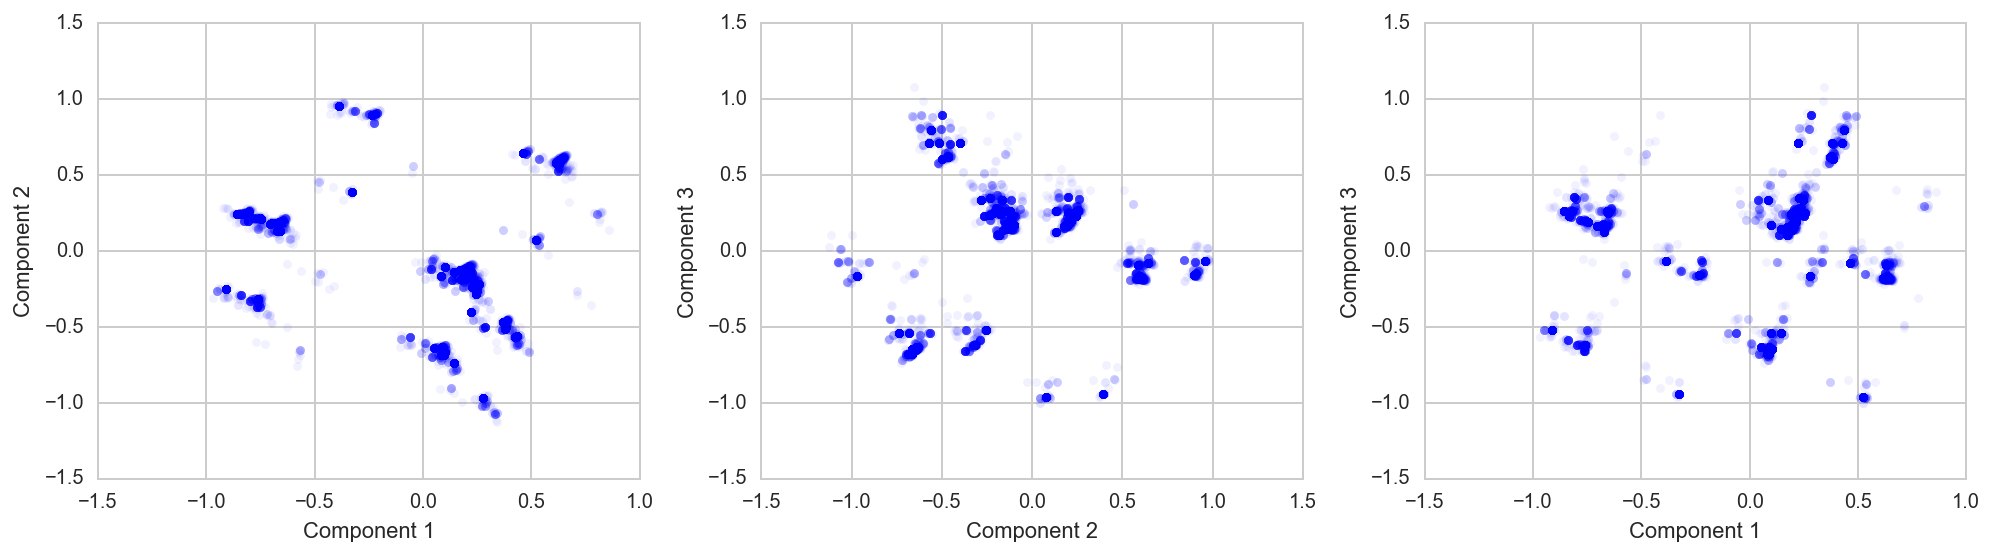

In [17]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=0.05, lw=0)
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
fig.tight_layout()

There appears to be some structure revealed in the top principal components. Let's use matplotlib's `hexbin` to get an idea of the point density, which may not be apparent from the scatter plots.

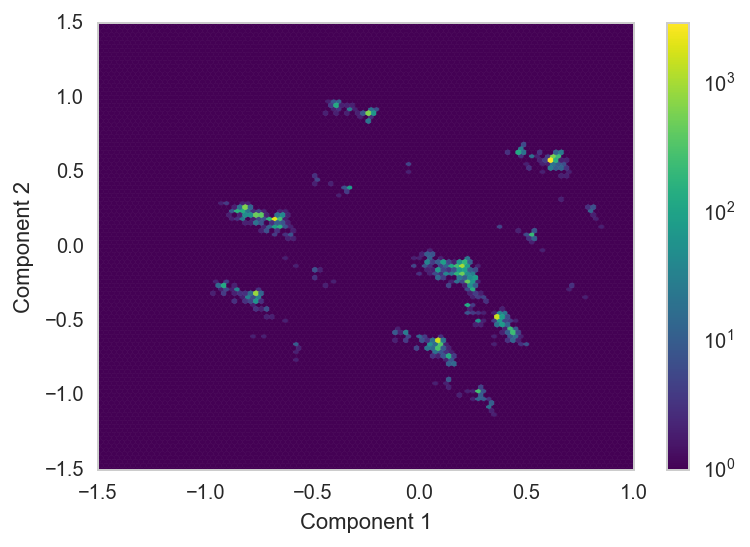

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
hb = ax.hexbin(components[:,0], components[:,1], cmap=plt.cm.viridis, extent=(-1.5, 1, -1.5, 1.5), norm=LogNorm());
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
fig.colorbar(hb)

In some regions there are nearly 10,000 overlapping data points! We definitely have distinct clusters on our hands. How can we effectively detect them?

## Clustering genres

Clustering will allow us to detect groups of similar data points. By clustering the results from our dimensionality reduction, we should be able to meaningfully partition our data into different groups.

### $k$-means

$k$-means is a relatively quick, low cost clustering algorithm that requires us to guess the number of clusters ($k$) beforehand (for an overview of how it works, you can check out my example implementation [here](http://jonchar.github.io/notebooks/k-means/)). However we don't necessarily have a clear estimate for $k$. How many clusters are apparent in the `hexbin` plot above? 2? 6? More? The truth is that there is no correct answer.

One way to come up with an estimate is to run $k$-means with different values for $k$ and evaluate how well the clusters fit the shape of the data. We can then use the "hockey stick" method (that's a technical term) and choose the value for $k$ where the most significant bend occurs in the plot. The measure of how well the clusters fit is known as the [inertia](http://scikit-learn.org/stable/modules/clustering.html#k-means) and reflects the variability within clusters. This [isn't the only way to determine the optimal number of clusters](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set), but it's what we'll use here. We'll run this using the first 3 principal components.

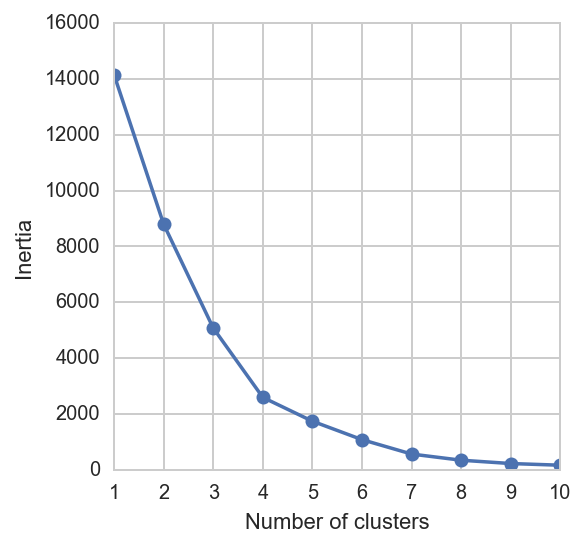

In [19]:
distortions = []
for n in np.arange(1,11):
    kmeans = KMeans(n_clusters=n)
    clusters = kmeans.fit_predict(components[:,[0,1,2]])
    distortions.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.arange(1,11), distortions, marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_ylim(0, ax.get_ylim()[1]);

Depending on what you think hockey sticks look like, $k$-means suggests either 4 or 7 clusters. Let's see what 4 clusters looks like.

In [20]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(components[:,[0,1,2]])

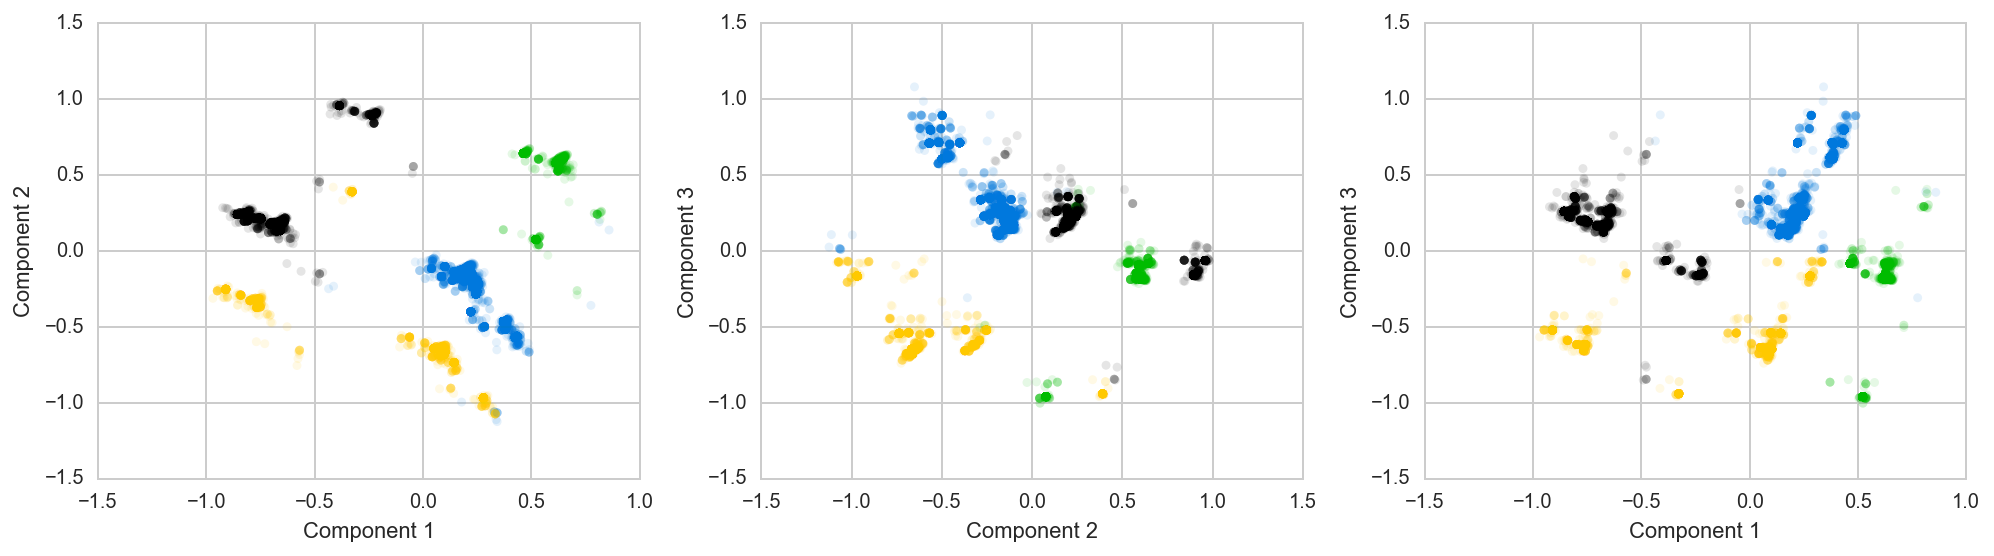

In [21]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=0.1, lw=0, color=plt.cm.spectral(clusters/n_clusters))
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
fig.tight_layout()

Hmm...4 clusters doesn't look that great. Does 7 look any better?

In [22]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(components[:,[0,1,2]])

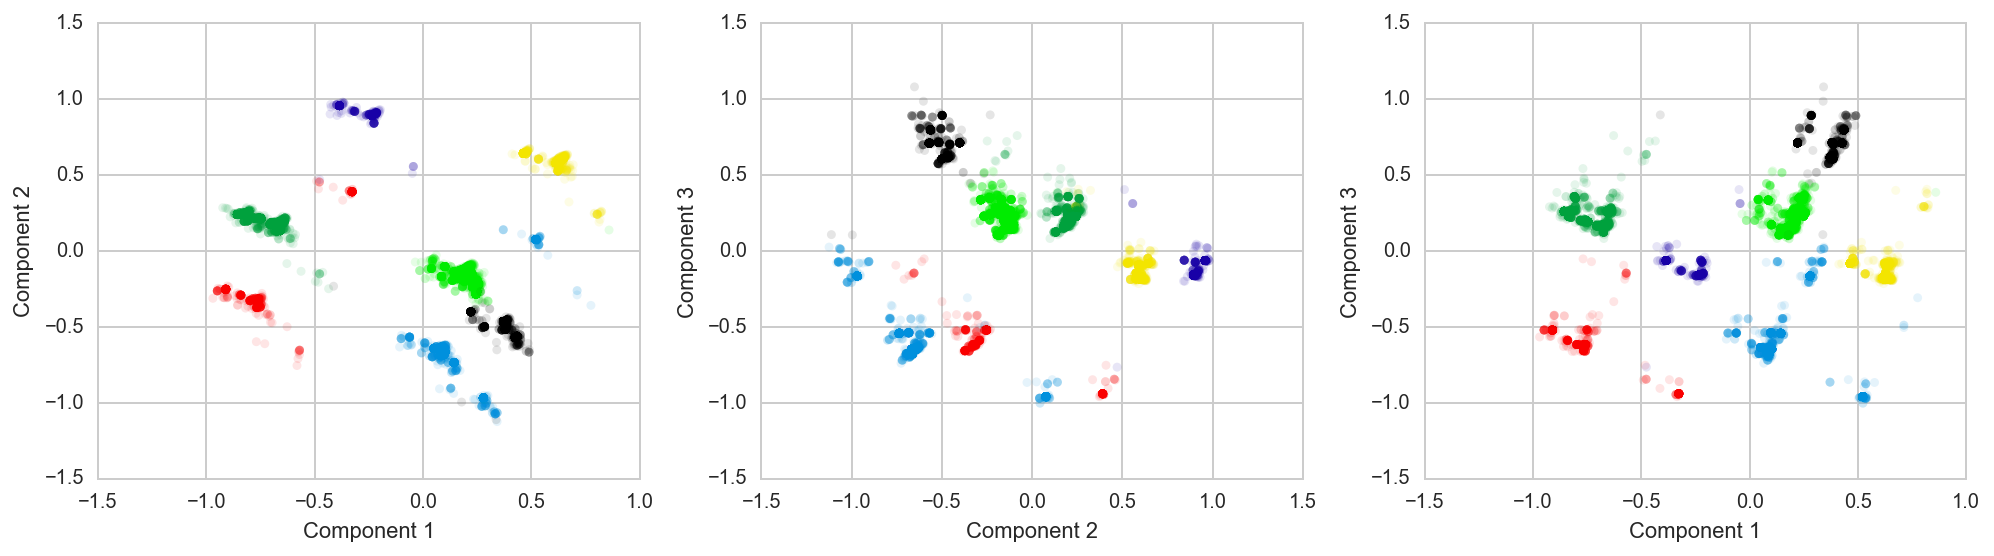

In [23]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=0.1, lw=0, color=plt.cm.spectral(clusters/n_clusters))
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
fig.tight_layout()

Better, but still not quite right. The 4 or 7 clusters suggested by $k$-means doesn't seem to fit our clusters visually. Perhaps $k$-means isn't the best approach.

Our clusters are not very circular in shape, and from our `hexbin` plot above, we know they are very dense. This is probably why $k$-means fails to give us nice looking clusters -- it assumes roughly spherical clusters and doesn't directly care about density. If only there was a clustering algorithm that was based on density and could identify the seemingly arbitrary shapes we have...

Oh yeah, there's density-based spatial clustering of applications with noise (DBSCAN)!

### DBSCAN

DBSCAN differs from $k$-means in that you do not need to specify the number of clusters and it defines clusters based on how densely they are packed. However, you do need to specify $\epsilon$, a length parameter that defines the maximum distance between points in a cluster. We'll choose $\epsilon$ to be 0.1 (there are methods of choosing this, but by eye our data looks like 0.1 will work well). You can imagine that there may be edge cases where a point does not fit into any cluster. In this case, DBSCAN labels the point as noise (cluster -1).

In [24]:
db = DBSCAN(eps=0.1, min_samples=40)
db_clust = db.fit_predict(components[:,[0,1,2]])

In [25]:
np.unique(db_clust) # Number of clusters

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

Hey, 10 clusters with some noise sounds great! The noise cluster is colored in black below.

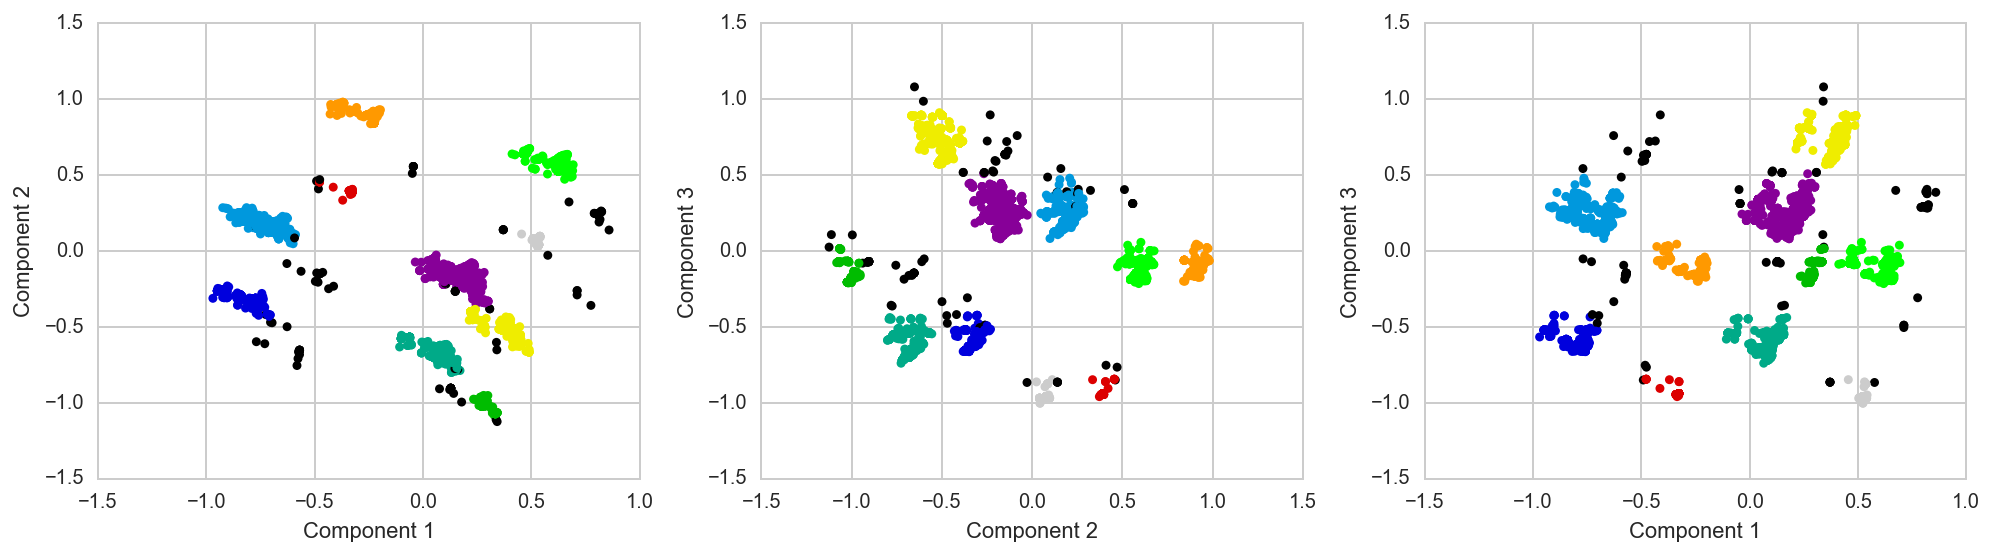

In [26]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=1, lw=0,
                  color=plt.cm.spectral((db_clust+1)/max(db_clust+1)))
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
fig.tight_layout()

This looks much better than the $k$-means results do. But what do our clusters mean? Let's list the top three genre descriptor terms in each cluster.

In [27]:
descriptors = data['Genre'][subset.index]  # Unprocessed descriptor strings
clusters = np.unique(db_clust)

for cluster in clusters:
    print('Cluster {}:'.format(cluster))
    cluster_term_sets = descriptors[db_clust == cluster]            # pull out genre terms, concatenate
    terms, counts = np.unique(cluster_term_sets, return_counts=True) # find unique terms within centroid
    df = pd.DataFrame([terms, counts], index=['top terms', 'counts']).T
    df.sort_values('counts', ascending=False, inplace=True)
    for i, (term, count) in df.head(3).iterrows():
        print('\t{} : {}'.format(term, count))

Cluster -1:
	Heavy/Black Metal : 7
	Heavy/Thrash/Death Metal : 6
	Melodic Heavy/Thrash Metal : 6
Cluster 0:
	Progressive Metal : 400
	Power Metal : 375
	Gothic Metal : 186
Cluster 1:
	Death/Thrash Metal : 492
	Thrash/Death Metal : 308
	Melodic Death/Thrash Metal : 99
Cluster 2:
	Death Metal : 1905
	Melodic Death Metal : 556
	Brutal Death Metal : 435
Cluster 3:
	Thrash Metal : 1531
	Thrash/Groove Metal : 148
	Thrash Metal/Crossover : 128
Cluster 4:
	Heavy/Thrash Metal : 207
	Thrash/Heavy Metal : 53
	Heavy/Power/Thrash Metal : 9
Cluster 5:
	Black Metal : 2708
	Raw Black Metal : 137
	Melodic Black Metal : 121
Cluster 6:
	Heavy Metal : 1491
	Heavy/Power Metal : 200
	Heavy Metal/Hard Rock : 193
Cluster 7:
	Black/Death Metal : 422
	Death/Black Metal : 183
	Melodic Black/Death Metal : 62
Cluster 8:
	Black/Death/Thrash Metal : 35
	Death/Black/Thrash Metal : 15
	Thrash/Death/Black Metal : 10
Cluster 9:
	Black/Thrash Metal : 152
	Thrash/Black Metal : 45
	Black/Speed/Thrash Metal : 5


Nice, our clusters seem to make sense by grouping similar genre decriptors!

# Part II: Exploring clusters

Before moving forward, let's shift the cluster assignments to go from 0 through 10 and give each one a specific hex color for consistency. These colors should correspond with the colors in the scatter plot above, with the noise cluster (now cluster #0) as black. The colormap used here is `plt.cm.spectral`. I like this one because the colors are relatively bright and not muted as they are in `plt.cm.Paired`. Feel free to use another one if you so desire.

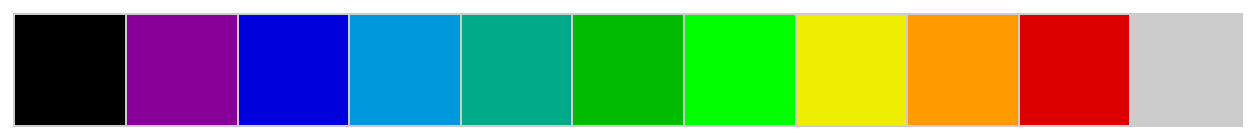

In [28]:
db_clust = db_clust + 1
clusters = list(np.unique(db_clust))
colors = [rgb2hex(color) for color in plt.cm.spectral(clusters/max(clusters))]
sns.palplot(colors)

### How large are our clusters?

Let's visualize the number of bands in each cluster using a simple bar graph to get an idea of their relative sizes.

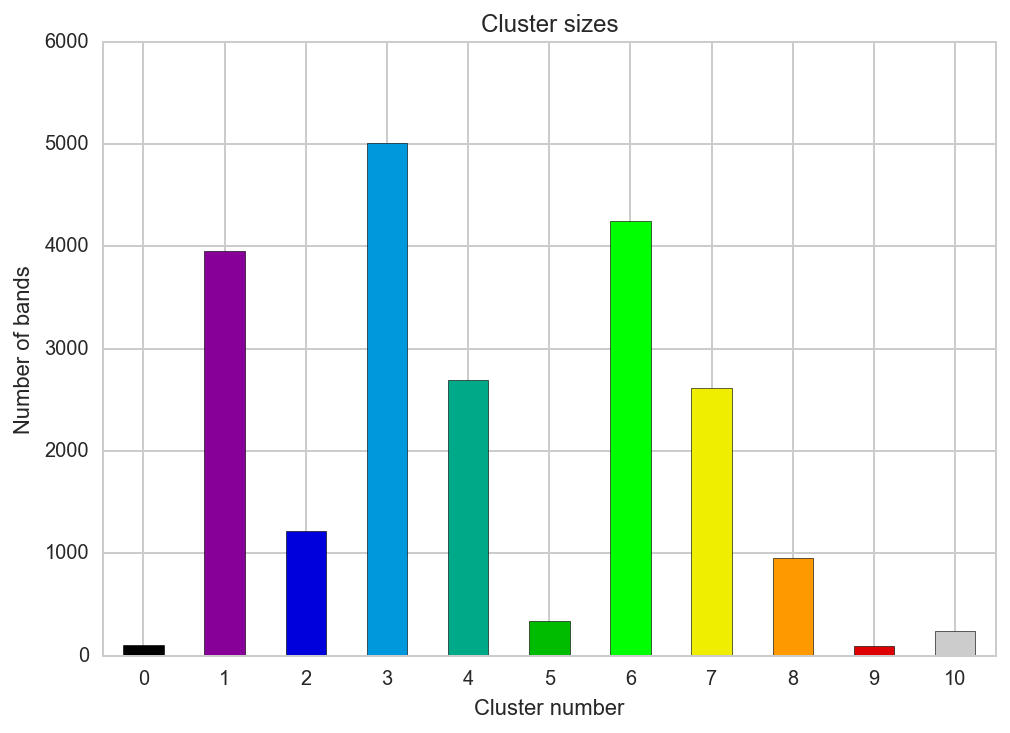

In [29]:
x = np.arange(len(clusters))
sizes = [db_clust[db_clust == cluster].size for cluster in clusters]
width = 0.5

fig, ax = plt.subplots()
ax.bar(x, sizes, width=width, color=colors, align='center')
ax.set_xlim(x[0]-width, x[-1]+width)
ax.set_xticks(x)
ax.set_xlabel('Cluster number')
ax.set_ylabel('Number of bands')
ax.set_title('Cluster sizes')

Alright, looks like clusters 1, 3, and 6 are the largest. Our noise cluster is also fairly small. This may have been difficult to tell from just looking at the scatter plots above.

### Where are these clusters?

Another basic question we could ask of the data is: Which countries have the most metal bands?

In [30]:
counts_by_country = data.groupby('Country')['Genre'].count().sort_values(ascending=False)
counts_by_country[:10]

Country
United States     22701
Germany            9795
Italy              5775
Brazil             5081
France             4493
United Kingdom     4334
Sweden             4084
Finland            3404
Canada             3323
Poland             3054
Name: Genre, dtype: int64

The fewest bands?

In [31]:
counts_by_country[-10:]

Country
Guyana              2
Curaçao             1
Barbados            1
Aruba               1
French Polynesia    1
Mauritius           1
Bermuda             1
Zambia              1
Jamaica             1
Afghanistan         1
Name: Genre, dtype: int64

### Finding the top 10 countries per cluster

Now for each cluster we will make a plot of the top 10 countries represented within. To do this we'll use the DBSCAN cluster assignments to pick out records from our original data set. Next we'll group the data in that cluster by country, count the number of occurences of each, sort, and take the top 10. Also, since our cluster labels (the numbers 0 to 10) are not particularly informative, we'll also pick out the top three most common genre descriptors for each cluster and place them in the title alongside our cluster label. To easily get these counts, We'll write a short helper function.

In [32]:
def count_terms(series_of_term_tuples):
    """Takes an iterable containing iterables of the terms in a genre descriptor.
    Returns a data frame containing counts of all the terms, starting with the most common
    and ending with the least common."""
    all_terms = list(itertools.chain.from_iterable(series_of_term_tuples))
    terms, counts = np.unique(all_terms, return_counts=True)
    counted_terms = pd.DataFrame({'Term': terms, 'Count': counts})
    counted_terms.sort_values(by='Count', ascending=False, inplace=True)
    counted_terms.reset_index(inplace=True, drop=True)
    return counted_terms

Now we'll construct the visualization. We will plot both the *total number* of bands and the *total number of **active** bands*. We'll set a different alpha value for these two bars so they are differentiable from each other when overlaid.

This visuzalization will tell us *where each cluster is most popular*. Note that the y-axis labels are different for each cluster.

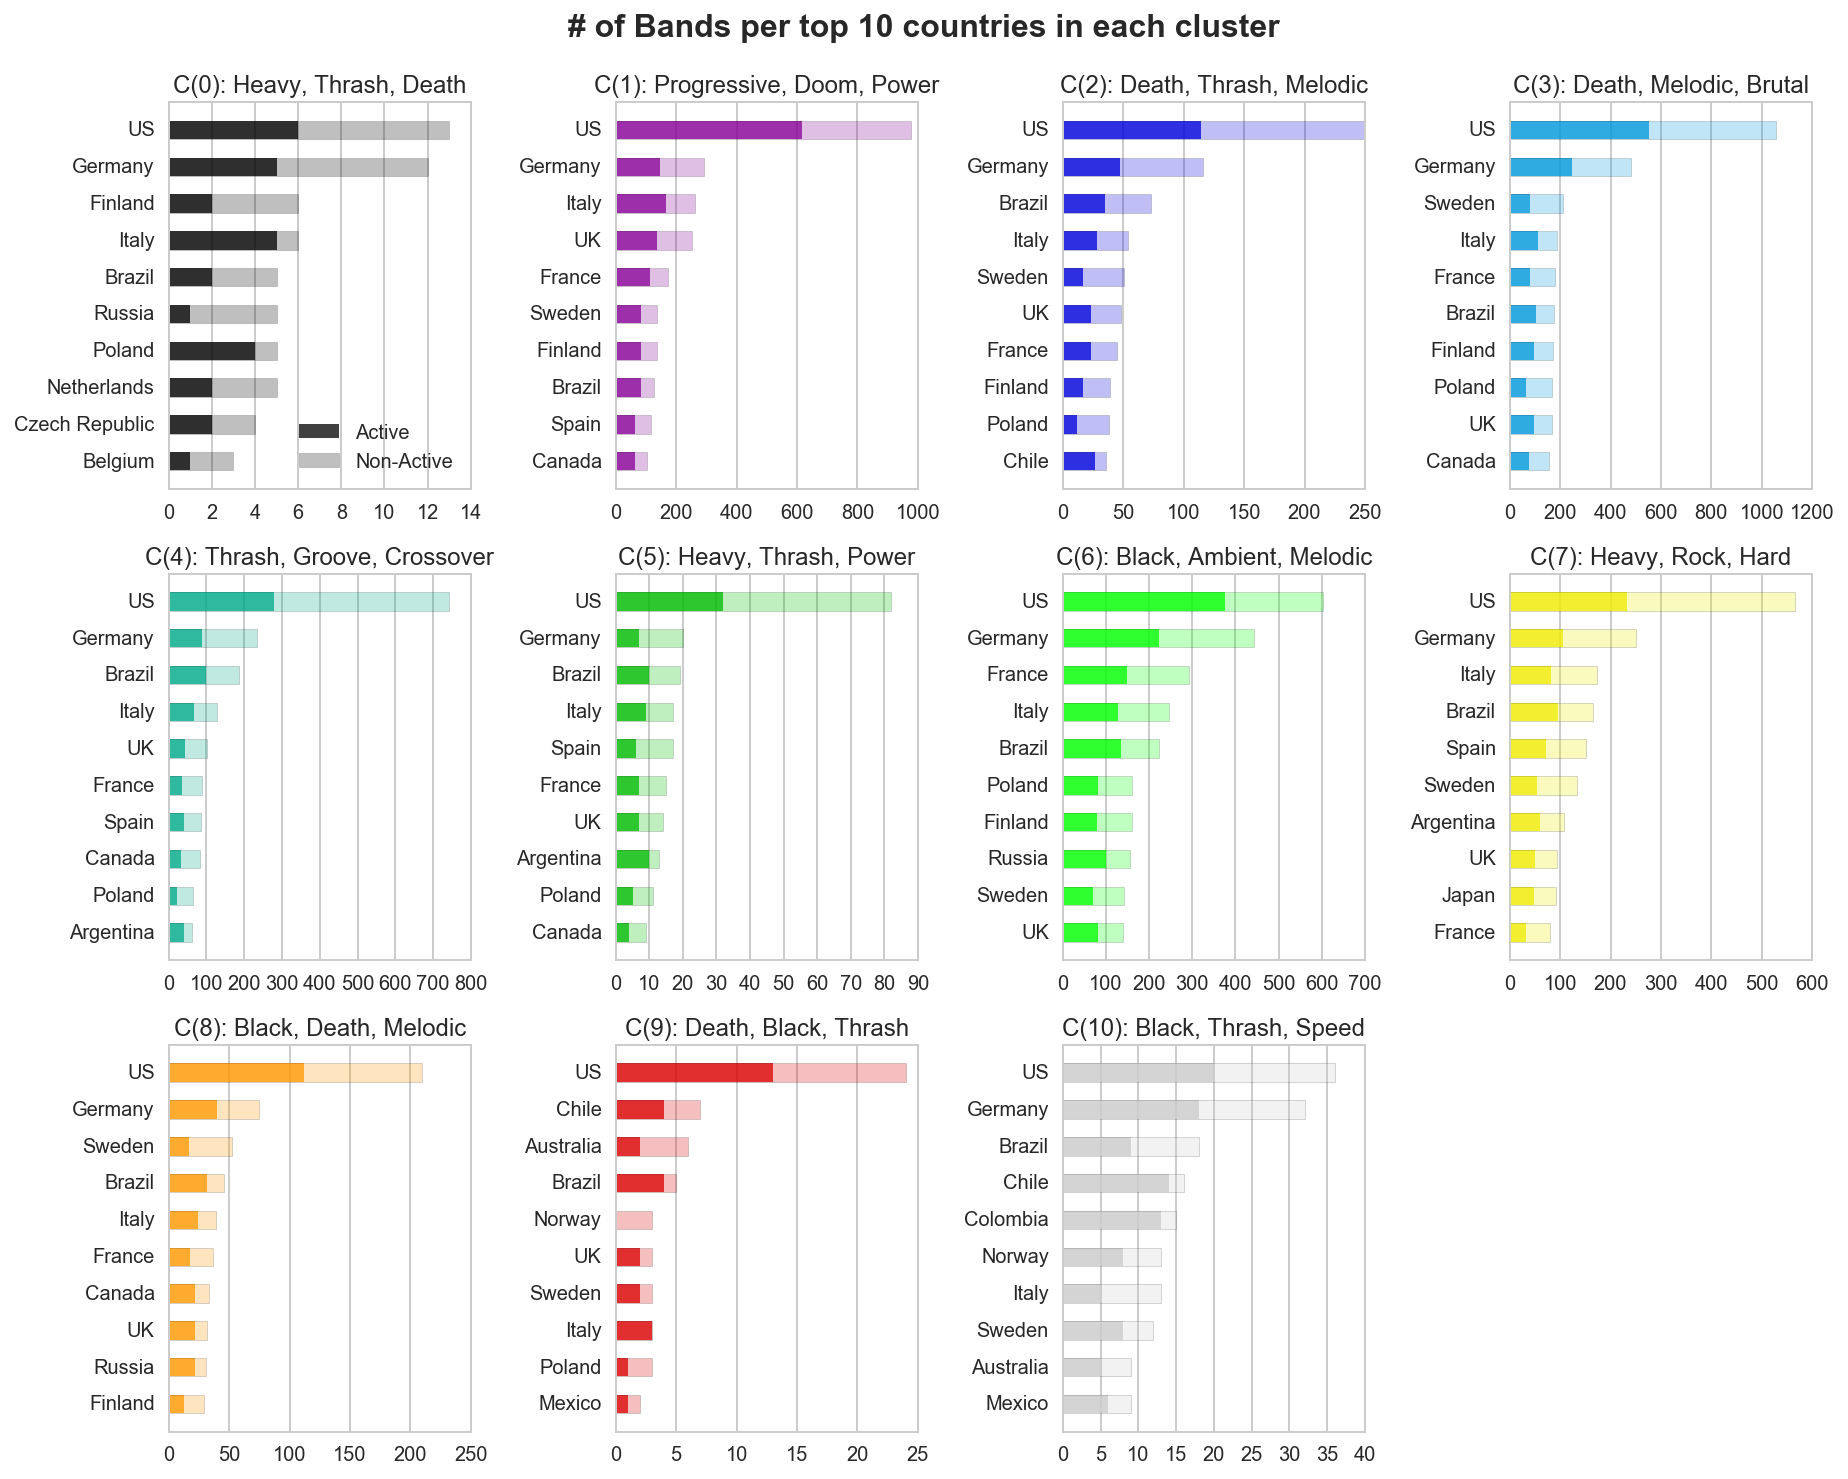

In [33]:
# We have 11 clusters which we can put on a 3x4 grid of plots, and disable the last  plot
fig, ax = plt.subplots(int(len(clusters)/4)+1,4,figsize=(13,10))

ax = ax.ravel() # This makes iterating over axes simpler 

for i, (cluster, axes) in enumerate(zip(clusters, ax)): # One plot per centroid
    # Pull out cluster genre data
    indices = subset[db_clust == cluster].index
    cluster_data = data.loc[indices]
    
    # Pull out counts per country, greatest first, also get number of active bands per country
    count = cluster_data.groupby('Country')['GenreTerms'].count().sort_values(ascending=False)
    count_active = cluster_data[cluster_data['Status'] == 'Active'].groupby('Country')['GenreTerms'].count()
    # Pull out top 3 most common terms
    term_count = count_terms(cluster_data['GenreTerms'])
    top_terms = term_count['Term'][:3]

    # Define color for cluster
    color = colors[cluster]
    # Define y-axis coordinates
    coords = np.arange(10, 0, -1)
    # kwargs for barh
    bar_kw = {'height': 0.5, 'color': color, 'align': 'center'}
    # Plot bars representing only active bands (note using index of original data)
    axes.barh(bottom=coords, width=count_active[count[:10].index], **bar_kw, alpha=0.75, lw=0, label='Active')
    # overlay horizontal bars representing all bands
    axes.barh(bottom=coords, width=count[:10], **bar_kw, alpha=0.25, label='Non-Active')
    if i == 0:
        axes.legend(frameon=False, loc=0)
    # Set title using 3 most common terms from cluster
    axes.set_title('C({}): {}, {}, {}'.format(cluster, *top_terms))
    # Format country labels, shorten longer names for more compact layout
    axes.set_yticks(coords)
    ticklabels = count[:10].index
    ticklabels = ticklabels.str.replace('United States', 'US').str.replace('United Kingdom', 'UK')
    axes.set_yticklabels(ticklabels, ha='right', va='center')

    # Format plot
    axes.set_ylim(0.25, 10.75)
    axes.grid('off', axis='y')

# Hide last plot
ax[-1].set_axis_off()

fig.tight_layout()
fig.suptitle('# of Bands per top 10 countries in each cluster', y=1.025, fontsize=16, weight='bold')

The fact that the US is at the top of each cluster is probably because they have the most bands (see above), but it seems as though nearly half of their total bands for each cluster are non-active.

### Everyone loves word clouds

Word clouds are everyone's favorite visualization that looks cool while simultaneously not telling you all that much about the data. High on the wow factor and not so high on the quantitative information delivered. Why not make some for our clusters?

The `WordCloud` class from the [`wordcloud`](https://github.com/amueller/word_cloud) library has a `generate()` method that takes a string of words to construct the word cloud. For each cluster, we'll concatenate the tokenized genre descriptor terms from all records in a cluster.

In [34]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


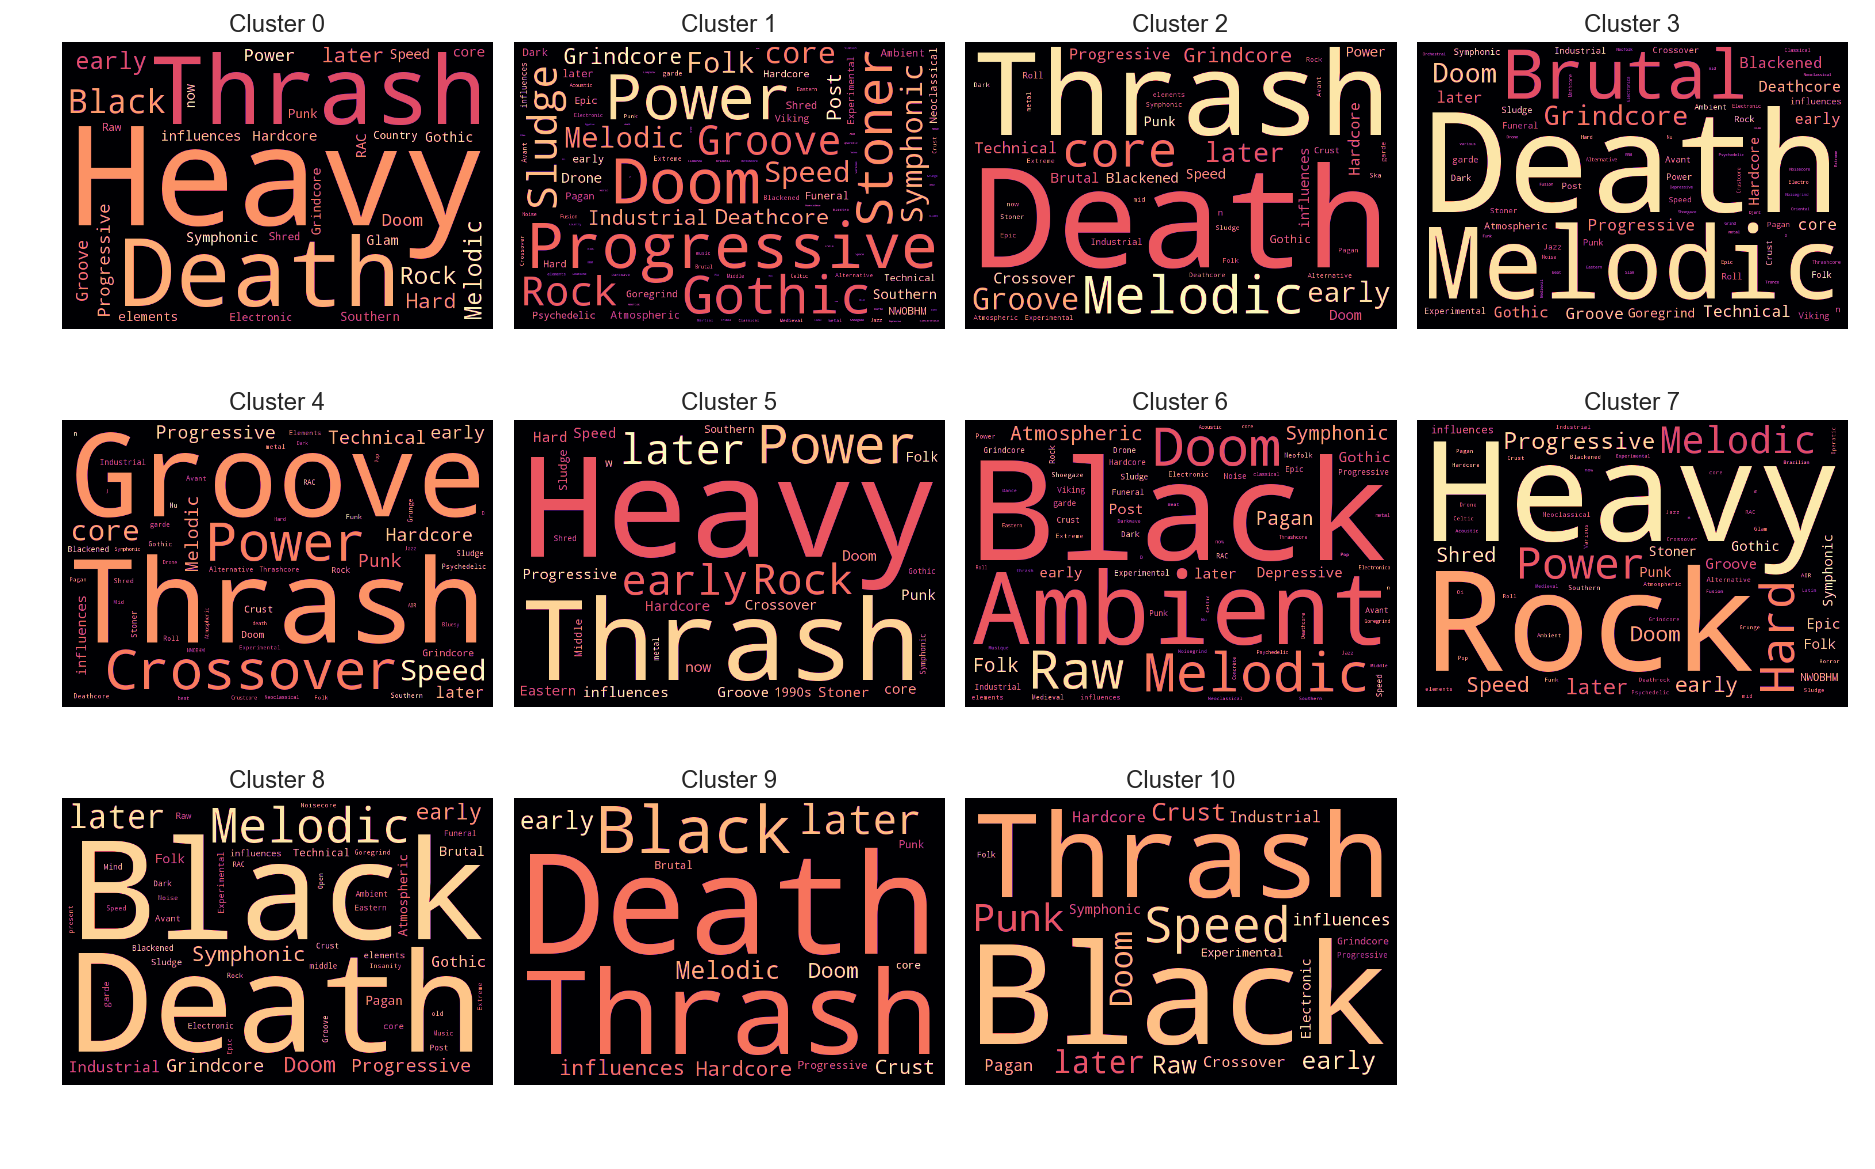

In [35]:
# We have 11 clusters which we can put on a 3x4 grid of plots, and disable the last plot
fig, ax = plt.subplots(int(len(clusters)/4)+1,4,figsize=(16,10))

ax = ax.ravel()
ax[-1].set_axis_off()

for i, (cluster, axes) in enumerate(zip(clusters, ax)): # One plot per cluster
    # Pull out indices for the cluster
    indices = subset[db_clust == cluster].index
    # Get tokenized terms from original data set
    cluster_data = data.loc[indices]['GenreTerms'].values
    all_cluster_terms = itertools.chain.from_iterable(cluster_data)
    # Set up word cloud
    wc = WordCloud(width=750, height=500, random_state=i, margin=20, background_color='black')
    # Set color function to generate a grayscale cloud
    wc.color_func = grey_color_func
    # Generate cloud
    wc.generate(' '.join(all_cluster_terms))
    # Pull out one layer (all 3 RGB layers are the same, as the image is grayscale)
    img = wc.to_array()[:,:,0]
    # Show the cloud
    axes.imshow(img, cmap=plt.cm.magma) # Use the most metal colormap
    axes.set_axis_off() # Hide axes
    axes.set_title('Cluster {}'.format(cluster))
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

## A network of genres

Now that we know our data has underlying structure, we can proceed to build a network or graph representation of our data. Graphs are defined by a series of nodes representing entities and edges representing relationships between those entities. Here I'll use the terms network and graph interchangeably.

### Constructing graphs in Python with NetworkX

The package [`networkx`](https://networkx.github.io/) (imported up top as `nx`) provides the functionality to make graphs in Python. You can create a graph using networkx first by instantiating a `Graph` object and then adding nodes or edges. Adding nodes is simple, you use the `Graph.add_node()` (or `Graph.add_nodes_from()`) method and pass in any hashable Python object(s). For edges you use the `Graph.add_edge()` (or `Graph.add_edges_from()`) method and pass in a pair (or iterable of pairs) of hashable Python objects. If you add an edge that contains a node not previously added to the graph, networkx will automatically add that node to your graph. Due to this functionality, you can define a graph simply by defining only a series of edges between nodes. This is the method we'll use to make our graph.

Before we make a graph though, we need to come up with a definition that fits our data.

### Intuitive and simple graph definition

One way we can make a graph out of our data set is if we imagine each band as a node and we imagine edges existing between bands with overlapping genre terms. For example, all bands labelled as "Death Metal" would be connected to each other, as well as all bands labelled "Thrash/Death Metal". This conceptualization, while simple, has the potential to produce a very heavily connected graph that may be unwieldy to construct.

In [36]:
genre_terms.head()

,Term,TotalCount
94,Death,36633
69,Black,27528
227,Thrash,23336
137,Heavy,15421
156,Melodic,9495


Even though we are dealing with a subset of the data (1/5th), that means there are probably at least 7000 bands with the term "Death" in their genre descriptor That means we would have to draw $_{7000}C_2$ or $\frac{7000!}{2\cdot6998!}$edges! That's far too many to draw on a single computer or use in a practical and informative graph representation. Another approach is necessary here.

### Slightly more complex but practical definition

Seeing that we have identified clusters based on genre descriptors, perhaps we can construct a graph using *unique genres as nodes*, and still construct *edges between genres that share terms*. We could then also size the nodes as a function of the number of bands within the genre that the corresponding node represents. We could also color each node based on that genre's cluster assignment. Based on this definition we need the following to construct our graph:

1. Binarized label vector for each unique genre (this will be a matrix of shape `n_unique_genres` by `n_unique_terms`)
2. Number of bands within, and cluster assignment (from DBSCAN above) for each unique genre

The data in (1) will allow us to generate the nodes and edges of our graph, while the data in (2) will be used to define node size and color.

#### Reorganizing the data

Going by the definition described above, we need to reorganize our data as follows. Steps 1 through 4 prepare what we need for our nodes and steps 5 and 6 prepare what we need for the edges.

1. Collapse our `subset` into unique rows (these are the unique genres), retaining counts & indices for each unique genre.
2. Pick out the corresponding binary representation of each unique genre.
3. Put these together into a single data frame, along with the cluster assignment of each node.
4. Pull out only unique genres with more than N bands. This will cut out some obscure genres but make the graph easier to visualize.
5. Get indices of connected nodes using rows where corresponding genre term's column is equal to 1 in the binary representation of the unique genres.
6. Construct our edges using `itertools.combinations`.

##### Preparing the nodes

In [37]:
# Step 1 above
genre_uniques, genre_indices, genre_counts = np.unique(subset, return_counts=True, return_index=True)

Next, we'll pick out corresponding binarized vectors for each unique genre. Remember, rows in the series `subset` correspond directly with those in `binarized_terms`, so we can use the indices picked out by `np.unique()` above.

In [38]:
# Step 2 above
binarized_genres = binarized_terms[genre_indices]
binarized_genres.shape # (n_unique_genres x n_unique terms)

(2210, 293)

Now we will construct a data frame with the counts for each unique genre, but set the index to correspond with where the term occurs in our original scraped data frame `data`. This way we can reference back to any of the original information we scraped.

In [39]:
# Step 3 above
genre_counts_df = pd.DataFrame(data={'Genre': genre_uniques, 'Count': genre_counts},
                               index=subset.index[genre_indices])

And let's check what the top genres are by sorting our counts.

In [40]:
genre_counts_df.sort_values('Count', ascending=False).head()

,Count,Genre
50,2708,"(Black,)"
10,1906,"(Death,)"
55,1534,"(Thrash,)"
110,1493,"(Heavy,)"
120,556,"(Melodic, Death)"


Finally, we will concatenate the binarized vectors for each unique genre term, a vector of cluster assignments for each unique genre, and our data frame containing the counts. That way we'll have all of the information to construct our graph conveniently in a single data structure.

In [41]:
# Still step 3
binarized_genre_df = pd.DataFrame(binarized_genres, columns=unique_terms, index=genre_counts_df.index)
genre_cluster_assign = pd.Series(db_clust[genre_indices], name='Cluster', index=genre_counts_df.index)
network_data = pd.concat([genre_counts_df, genre_cluster_assign, binarized_genre_df], axis=1)

In [42]:
network_data.head()

,Count,Genre,Cluster,1977,1980,1980s,1981,1982,1983,1984,...,roll,s,since,thrash,tribal,until,various,w,with,​​
26220,1,"(AOR, Funk, Early, Thrash, Crossover, Mid, Pop...",4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10155,1,"(AOR, early, Power, Progressive, later)",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53380,2,"(Acoustic,)",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67550,1,"(Acoustic, Doom, early, Acoustic, later)",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91405,1,"(Acoustic, Folk)",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What's useful about this format is that we can filter out smaller genres based on the number of bands within the genre. For example, we can only include genres with 25 or more bands.

In [43]:
# Step 4 above, notice no counts less than 25 (this is an arbitrary cutoff)
min_bands = 25 # Each band included must have at least min_bands
network_data_subset = network_data[network_data['Count'] >= min_bands]
network_data_subset.head()

,Count,Genre,Cluster,1977,1980,1980s,1981,1982,1983,1984,...,roll,s,since,thrash,tribal,until,various,w,with,​​
7660,28,"(Ambient, Black)",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1415,89,"(Atmospheric, Black)",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,2708,"(Black,)",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340,66,"(Black, Ambient)",6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,424,"(Black, Death)",8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Preparing the edge list

Now that our node data is prepared, we need to construct a list of edges (pairs of connected nodes). We can do this easily using the data frame `network_data` that we defined above. We can collect the index of all rows (unique genres) where a specific column (unique genre term) is equal to 1. The genres at these indices will all share that genre descriptor, and should all be connected to each other given our graph definition above.

We'll write a function to generate an edge list for a given term. To generate this list of pairs we'll use `itertools.combinations`, which takes an iterable and an integer and returns all possible combinations of integer length of the items in the iterable.

In [44]:
# This function does steps 5 and 6 to prepare our edge list
def get_edge_list(term, data, return_generator=False):
    """Construct an edge list connecting all nodes (index values) where the value
    in column `term` of `data` is equal to 1. Returns a list of tuples by default.
    Pass in `generator=True` to return an `itertools.combinations` object instead."""
    mask = data[term] == 1
    indices = data[mask].index
    edge_list = itertools.combinations(indices, 2)
    if return_generator == True:
        return edge_list
    elif return_generator == False:
        return list(edge_list)
    else:
        raise TypeError("`return_generator` kwarg must be a boolean.")

We'll use the above function to make a dict where the keys are unique genre terms and the values are their corresponding edge lists.

In [45]:
# We'll include all tokenized genre descriptor terms
terms = genre_terms['Term'].values
edge_lists = {t: get_edge_list(t, network_data_subset) for t in terms} # dictionary comprehension

### Enough processing, let's just make the graph already!

Just a few more lines...

In [46]:
G = nx.Graph() # Graph instance
for t in terms: # Add edges for each term
    G.add_edges_from(edge_lists[t])

### Now what does it look like?

So glad you asked. How do we draw our graph? Well, we use the `nx.{*}_layout` functions to position things. There are a few to choose from, but `nx.spring_layout` works nice. The layout function returns node positions. You have to use `nx.draw_networkx_{edges,nodes}` to actually draw the graph components. Remember we're using the number of bands in a unique genre to size the corresponding node, and the cluster assignment to color it.

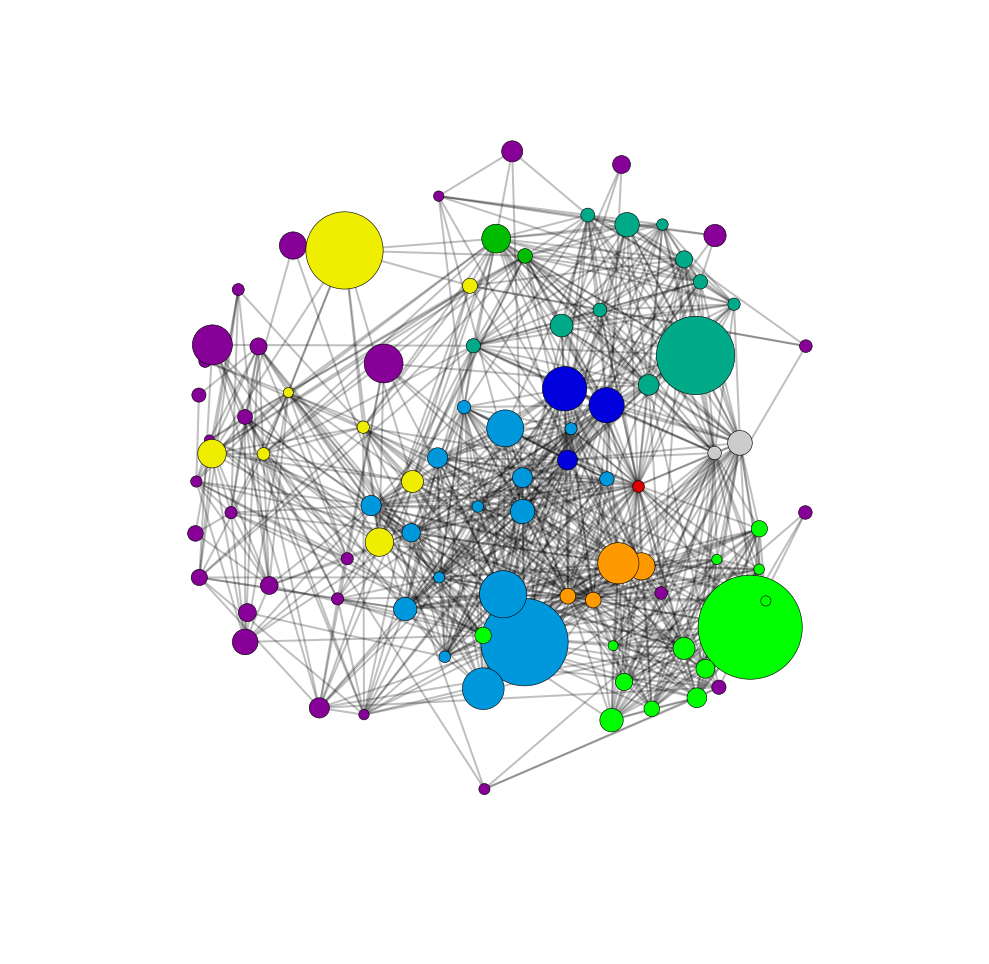

In [47]:
fig, ax = plt.subplots(figsize=(8,8))

# Define layout
pos = nx.spring_layout(G, k=0.25, iterations=20)

# Make sure we're using valid nodes
node_data = network_data_subset.ix[G.nodes()]

for cluster in clusters:
    # Set color based on cluster number
    color = colors[cluster]
    # Pull out node data for this cluster
    cluster_node_data = node_data[node_data['Cluster'] == cluster]
    # Get the actual nodes
    nodelist = list(cluster_node_data.index)
    # Set node sizes based on band count for each genre (node) 
    sizes = cluster_node_data['Count']
    # Draw them nodes all nice like
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=color, node_size=sizes)

# Draw those edges baby, and play with the alpha to make it look cooler
nx.draw_networkx_edges(G, pos, edge_list=G.edges(), alpha=0.25)
# No one likes axes behind their network visualizations for some reason
ax.set_axis_off()

Huh.

Underwhelming? Yeah I know. All that work for a not-so-pretty graph visualization.

## Enter the Circos plot

[Circos plots](circos.ca) were developed by [Martin Krzywinski](http://mkweb.bcgsc.ca/) at the [BC Cancer Research Center](http://www.bccrc.ca/).

In a Circos plot, the nodes are arranged in a circle and are ordered or grouped in some way. Some or all of the edges can then be drawn between them. Multiple plots can be combined into a panel where each subplot shows a subset of edges.

Code for drawing Circos plots in Python using matplotlib can be found on [PyPI](https://pypi.python.org/pypi/Circos) or on [Github](https://github.com/ericmjl/Circos).

For our data, we will draw a panel of Circos plots with the nodes grouped by cluster. Then in each subplot we will only draw the edges associated with a single cluster. This is a straightforward way to visualize how the clusters connect with each other.

We're going to make one plot for each cluster and only draw edges that connect with that cluster. I'm omitting cluster #0 as that is our noise cluster and it didn't contain any unique genres that had band counts above our cutoff of 25.

In [48]:
network_data['Cluster'].unique()

array([ 4,  1,  3,  2,  6,  7,  8,  0,  9, 10,  5])

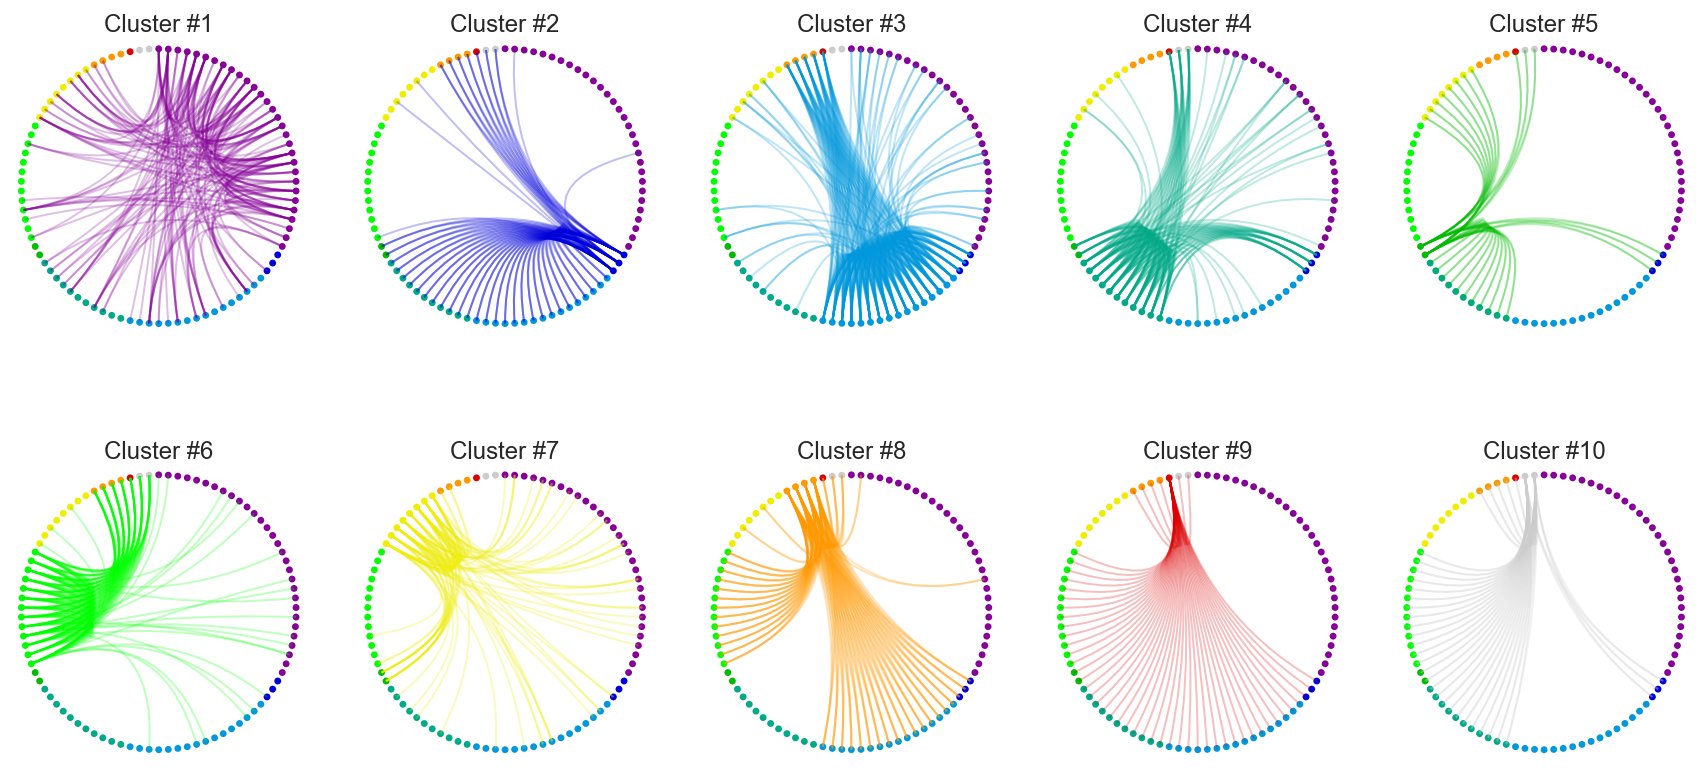

In [49]:
nodes = list(network_data['Cluster'][G.nodes()].sort_values().index.values)
nodecolor = network_data['Cluster'][nodes].map(lambda x: colors[x])
edgeprops = {'alpha': 0.25}

fig, ax = plt.subplots(2,5,figsize=(15,7))
ax = ax.ravel()

for axes, cluster in zip(ax, clusters[1:]):
    # Pick out only the edges associated with the current cluster
    edges = [(u, v) for u, v in G.edges() if (network_data['Cluster'][u] == cluster) or (network_data['Cluster'][v] == cluster)]

    c = CircosPlot(nodes, edges, radius=1,
                   nodecolor=nodecolor, edgecolor=colors[cluster], edgeprops=edgeprops,
                   figsize=(1.25,1.25), fig=fig, ax=axes)
    c.draw()
    axes.set_aspect('equal') # Keep our axes aspect ratio 1:1, thus keeping node arrangements circular
    axes.set_title('Cluster #{}'.format(cluster))

Now we easily can see relationships between our clusters. We can easily notice how Cluster 9 doesn't overlap at all with Clusters 1 and 7. This visualization method is far more informative than our previous attempt.

## Conclusion

To recap, we've scraped data, processed it into a feature matrix, applied dimensionality reduction, found clusters based on density, and built a network representation of how these clusters relate to one another based on shared features. This was focusing primarily on the genre descriptors in the original scraped data. Our clusters represent groups of related metal subgenres. This approach could easily be applied to other sets of musical genres, or&mdash;more broadly&mdash;sets of short phrases with common wonds. There are plenty of other avenues to explore even with this simple data set.

We've gone all the way from scraping data from the web to making informative visualizations. We did this all using Python and open source libraries. Pretty cool!

### Potential Application

One application of this approach would be for building a band (or song) recommendation engine. With a database of bands and corresponding genres in hand, the above analysis could be performed, generating clusters of genres and their semantic relationships to each other. To recommend a new band to the listener, a user could upload a list of bands (or genres) they like, and a recommendation would be made based on the cluster distributions of the genres in the list. If a listener instead desires a departure from their normal listening habits, the model could choose a band that falls outside of the predominant clusters in their uploaded band list. Of course, the band list could be easily replaced with listening history or even ratings of some kind, which could then determine weights that could be applied to the clusters in the listener's history. Since the PCA and clustering is relatively cheap computationally, one could imagine constructing clusters on a per-listener basis, a highly customized approach.

The one drawback is that these are based solely on semantic labels (genres). Even within a single genre there can be considerable variation. Adding other feature sets in addition to the semantic ones described here would likely improve the model. Even so, the preference of a specific listener may be based on things far outside of the semantic labels or quantifiable metrics one building the model could obtain, such as personal experience and memory.